# **CONSTANTS AND HYPERPARAMETERS**


In [81]:
# data processing
CPI = 5                         # number of captions per image
MAX_LEN = 100                   # length of padded captions
MIN_WORD_FREQ = 5               # words occuring less than this threshold will be labelled as <unk>

# Model architecture
BATCH_SIZE = 32
NUM_WORKERS = 4
EMBED_DIM = 512                 # dimension of word embeddings
ATTENTION_DIM = 512             # dimension of attention linear layers
DECODER_DIM = 512               # dimension of decoder RNN
ENCODER_DIM = 2048
GRAD_CLIP = 5.                  # clip gradients at an absolute value of
ALPHA_C = 1.                    # regularization parameter for 'doubly stochastic attention'
DROPOUT = 0.2

# Training
LEARNING_RATE_DECAY_FACTOR = 0.8
LEARNING_RATE_DECAY_PATIENCE = 8
ENCODER_LEARNING_RATE = 1e-4    # learning rate for encoder if fine-tuning
DECODER_LEARNING_RATE = 5e-4    # learning rate for decoder
START_EPOCH = 1
EPOCHS = 15
EPOCHS_SINCE_IMPROVEMENT = 0    # keeps track of number of epochs since there's been an improvement in validation BLEU

FINE_TUNE_ENCODER = False       # fine-tune encoder

# Text generation
BEAM_SIZE = 5

In [2]:
# path
# BASE_PATH = '/gdrive/MyDrive/CSE455/ImageCaptioning/'

BASE_PATH = '/home/qthai912_cs_washington_edu/CSE455/COCO_Image_Captioning/'

DATA_PATH = BASE_PATH + 'data/'
LOG_PATH = BASE_PATH + 'logs/log.pkl'
CAPTION_PATH = BASE_PATH + 'annotations/'
TORCH_SAVE_PATH = BASE_PATH + 'torch_save/'

# **0. Setup**

In [ ]:
!pip install transformers

In [ ]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.13 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
thinc 8.0.13 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
spacy 3.2.2 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is inc

In [ ]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:00


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 59.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage.transform
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm
from urllib.request import urlretrieve
import gensim


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import RandomSampler, Subset
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings("ignore")

In [4]:
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# !ls /gdrive

In [5]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

Version 1.10.0
CUDA enabled: True


In [5]:
# create paths if not existed
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

if not os.path.exists(CAPTION_PATH):
    os.makedirs(CAPTION_PATH)

if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

if not os.path.exists(TORCH_SAVE_PATH):
    os.makedirs(TORCH_SAVE_PATH)

os.chdir(BASE_PATH)

In [ ]:
os.chdir(DATA_PATH)

# !wget http://images.cocodataset.org/zips/train2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
# !wget https://ivc.ischool.utexas.edu/VizWiz_final/images/test.zip
# !unzip train2014.zip
# !unzip val2014.zip
# !unzip test.zip
# !rm -r 'train2014.zip'
# !rm -r 'val2014.zip'

os.chdir(BASE_PATH)

In [6]:
os.chdir(BASE_PATH)
# !wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
# !unzip 'caption_datasets.zip'
# !rm -r 'caption_datasets.zip'
os.chdir(BASE_PATH)

In [7]:
print("# of images [training]: {}".format(len(os.listdir(DATA_PATH + "train2014"))))
print("# of images [validation]: {}".format(len(os.listdir(DATA_PATH + "val2014"))))

# of images [training]: 82783
# of images [validation]: 40504


# **1. Load data**

In [8]:
# Load captions
with open('dataset_coco.json', 'r') as f:
    data = json.load(f)

word_freq = Counter()       # Counter object to find the freq of each word

# Generate word mapping
for img in data['images']:
    for c in img['sentences']:
        # update word frequency
        word_freq.update(c['tokens'])

# Create word map (dictionary mapping words to ids with 0 reserved for padding)
words = [word for word in word_freq.keys() if word_freq[word] > MIN_WORD_FREQ]
word2id = {word: id for id, word in enumerate(words, 1)}
word2id['<unk>'] = len(word2id) + 1
word2id['<start>'] = len(word2id) + 1
word2id['<end>'] = len(word2id) + 1
word2id['<pad>'] = 0

# Create reverse word map (dictionary mapping ids to words)
id2word = {value: word for word, value in word2id.items()}

In [9]:
# Split the images and captions into train, val and test
train_image_paths = []
train_image_captions = []
train_caption_lens = []

val_image_paths = []
val_image_captions = []
val_caption_lens = []

test_image_paths = []
test_image_captions = []
test_caption_lens = []

for img in data['images']:
    captions = []
    for c in img['sentences']:
        if len(c['tokens']) <= MAX_LEN:
            captions.append(c['tokens'])
    
    if len(captions) == 0:
        continue
    
    # Sample the captions randomly such that every image has same no of captions
    if len(captions) < CPI:
        captions += [random.choice(captions) for _ in range(CPI - len(captions))]
    else:
        captions = random.sample(captions, k=CPI)

    # Encode and pad captions
    enc_captions = []
    caption_lens = []
    for idx, caption in enumerate(captions):
        enc_caption = [word2id['<start>']] + [word2id.get(word, word2id['<unk>']) for word in caption] + [
                        word2id['<end>']] + [word2id['<pad>']] * (MAX_LEN - len(caption))
        
        # Find caption length (including start and end token)
        caption_len = len(caption) + 2

        enc_captions.append(enc_caption)
        caption_lens.append(caption_len)

    # Get the absolute path of image
    path = os.path.join(DATA_PATH, img['filepath'], img['filename'])

    # Add the image path, encoded caption to the list
    if img['split'] in {'train', 'restval'}:
        train_image_paths.append(path)
        train_image_captions.append(enc_captions)
        train_caption_lens.append(caption_lens)
    elif img['split'] in {'val'}:
        val_image_paths.append(path)
        val_image_captions.append(enc_captions)
        val_caption_lens.append(caption_lens)
    elif img['split'] in {'test'}:
        test_image_paths.append(path)
        test_image_captions.append(enc_captions)
        test_caption_lens.append(caption_lens)

# **2. Load data into DataLoader**

In [10]:
class CaptionDataset(Dataset):
    def __init__(self, image_paths, captions, caption_lens, split, CPI=5, transform=None):
        """
        :param image_paths: the path the image is stored
        :param captions: the captions
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param CPI: number of captions per image
        :param transform: image transformation function
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        self.image_paths = image_paths
        self.captions = captions
        self.caption_lens = caption_lens
        self.CPI = CPI

        # Transformation for an image (normalization, cropping)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths) * self.CPI
    
    def __getitem__(self, idx):
        # Remember the Nth caption belongs to (N // CPI)th image
        img = Image.open(self.image_paths[idx // self.CPI]).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (256, 256))

        if self.transform is not None:
            img = self.transform(img)
        
        img = np.array(img)
        img = np.transpose(img, (2, 0, 1))
        img = torch.FloatTensor(img / 255.)

        caption = torch.LongTensor(self.captions[idx // self.CPI][idx % self.CPI])
        caption_len = torch.LongTensor([self.caption_lens[idx // self.CPI][idx % self.CPI]])

        if self.split is 'TRAIN':
            return img, caption, caption_len
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(self.captions[idx // self.CPI])
            return img, caption, caption_len, all_captions


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [82]:
whole_train_dataset = CaptionDataset(train_image_paths, train_image_captions, train_caption_lens, 'TRAIN')
train_dataset = Subset(whole_train_dataset, np.arange(10000))

In [83]:
# RandomSampler? https://lewtun.github.io/blog/til/nlp/pytorch/2021/01/24/til-slicing-torch-datasets.html
whole_val_dataset = CaptionDataset(val_image_paths, val_image_captions, val_caption_lens, 'VAL')
val_dataset = Subset(whole_val_dataset, np.arange(1000))
# val_dataset = val_dataset[:1000]
# whole_test_dataset = CaptionDataset(test_image_paths, test_image_captions, test_caption_lens, 'TEST')
# test_dataset = Subset(whole_test_dataset, np.arange(2500))
# test_dataset = test_dataset[:2500]

In [137]:
test_dataset = Subset(whole_val_dataset, np.arange(1000, 10000))

## **a. Visualize data**

In [84]:
print(len(train_dataset))
print(len(val_dataset))
# print(len(test_dataset))

10000
1000


In [85]:
def decode_caption(enc_caption):
    dec_caption = [
        id2word[id]
        for id in caption.numpy()
        if id2word[id] not in ["<start>", "<end>", "<unk>", "<pad>"]
    ]
    return " ".join(dec_caption)

a kitchen area with toilet and various cleaning appliances



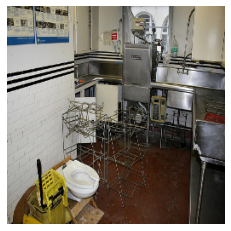

In [86]:
img, caption, caption_len = train_dataset[50]

print(decode_caption(caption))
print()

img_vis = plt.imshow(img.permute(1, 2, 0));
plt.axis('off')
plt.show()

a boy holding an umbrella while standing next to livestock
a young man holding an umbrella next to a herd of cattle
a child holding a flowered umbrella and petting a yak
a young boy with an umbrella who is touching the horn of a cow
a young boy barefoot holding an umbrella touching the horn of a cow



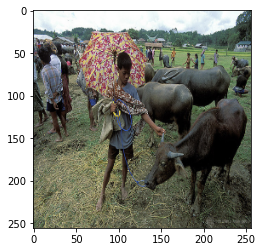

In [87]:
img, caption, caption_len, all_captions = val_dataset[0]

for caption in all_captions:
    print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0));

In [88]:
# Dataloader for train and val set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# Quick check to see if data is properly loaded or not
images, captions, caption_lens = next(iter(train_loader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])


In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
#                           shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
#                           shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [138]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# **3. Define ImageCaptioningModel**

## **a. Encoder (Image model)**

In [26]:
class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # Pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

        self.fine_tune()

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent computation of the gradients for convolutional blocks 2 through 4 of the image encoder.

        :param fine_tune: boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # if fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune
    
    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return enc_images: encoded repr of images, a tensor of dim (batch_size, enc_image_size, enc_image_size, 2048)
        """
        out = self.resnet(images)       # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)   # (batch_size, 2048, enc_image_size, enc_image_size)
        out = out.permute(0, 2, 3, 1)   # (batch_size, enc_image_size, enc_image_size, 2048)
        return out

## **b. Decoder (Captioning Model)**

### **b.1 Attention**

In [27]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)   # linear layer to transform encoder's output
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)   # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attention_dim, 1)

    
    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation (using Multiplicative attention).
        
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        attn1 = self.encoder_attn(encoder_out)          # (batch_size, num_pixels, attention_dim)
        attn2 = self.decoder_attn(decoder_hidden)       # (batch_size, attention_dim)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))    # (batch_size, num_pixels, 1)

        # Apply softmax to calculate weights for weighted encoding based on attention
        alpha = F.softmax(attn, dim=1)                  # (batch_size, num_pixels, 1)
        attn_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha

### **b.2 Decoder with Attention**

In [28]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim, dropout):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding_size
        :param decoder_dim: feature size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()
        self.attention_dim = ATTENTION_DIM
        self.embed_dim = EMBED_DIM
        self.decoder_dim = DECODER_DIM
        self.vocab_size = VOCAB_SIZE
        self.encoder_dim = ENCODER_DIM
        self.dropout = DROPOUT

        self.attention = Attention(ENCODER_DIM, DECODER_DIM, ATTENTION_DIM)     # attention network

        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)                    # embedding layer
        self.dropout = nn.Dropout(p=dropout)

        self.decode_step = nn.LSTMCell(EMBED_DIM + ENCODER_DIM, DECODER_DIM, bias=True) # decoding LSTMCell
        self.init_h = nn.Linear(ENCODER_DIM, DECODER_DIM)       # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(ENCODER_DIM, DECODER_DIM)       # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(DECODER_DIM, ENCODER_DIM)       # linear layer to create a sigmoid-activated gate

        self.fc = nn.Linear(DECODER_DIM, VOCAB_SIZE)            # linear layer to find scores over vocabulary
        
        self.init_weights()     # initialize some layers with the uniform distribution
    
    def init_weights(self):
        """
        Initialize some layers with the uniform distribution for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).

        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded_images, a tensor of dimension (batch_size, num_pixels, ENCODER_DIM)
        :return hidden_state, cell_state
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch_size, ENCODER_DIM)
        h = self.init_h(mean_encoder_out)   # (batch_size, DECODER_DIM)
        c = self.init_c(mean_encoder_out)   # (batch_size, DECODER_DIM)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, ENCODER_DIM)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        batch_size = encoder_out.size(0)

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, ENCODER_DIM)     # (batch_size, num_pixels, ENCODER_DIM)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by the decreasing caption length
        caption_lens, sort_idx = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        # Embedding
        embeddings = self.embedding(encoded_captions)   # (batch_size, max_caption_length, EMBED_DIM)

        # Initialize lstm state
        h, c = self.init_hidden_state(encoder_out)      # (batch_size, DECODER_DIM)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are caption lengths - 1
        decode_lens = (caption_lens - 1).tolist()

        # Create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), VOCAB_SIZE).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # At each time-step, decode by attention-weighing the encoder's output based on the 
        # decoder's previous hidden state output then generate a new word in the decoder with 
        # the previous word and the attention weighted encoding
        for t in range(max(decode_lens)):
            # Get the batch size for each time step t
            batch_size_t = sum([l > t for l in decode_lens])

            # Get the attention weighted encodings (batch_size_t, ENCODER_DIM)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = F.sigmoid(self.f_beta(h[:batch_size_t]))     # sigmoid gating scalar, (batch_size_t, ENCODER_DIM)
            attention_weighted_encoding = gate * attention_weighted_encoding

            # Get the decoder hidden state and cell state based on the embeddings of timestep t word 
            # and the attention weighted encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )   # (batch_size_t, DECODER_DIM)

            # Get the next word prediction
            preds = self.fc(self.dropout(h))    # (batch_size_t, VOCAB_SIZE)

            # Save the prediction and alpha for every time step
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
    
        return predictions, encoded_captions, decode_lens, alphas, sort_idx

# **4. Training and Evaluating**

## **Utils**

In [29]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [30]:
def clip_gradient(optimizer, GRAD_CLIP):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    
    :param optimizer: optimizer with the gradients to be clipped
    :param GRAD_CLIP: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-GRAD_CLIP, GRAD_CLIP)

## **a. Define train & eval functions**

In [31]:
def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    """
    Performs one epoch's training.

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """
    losses = []
    top5accs = []

    # Train mode (dropout and batchnorm is used)
    decoder.train()
    encoder.train()

    print_interval = 200

    for i, (imgs, caps, cap_lens) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # Move tensor to GPU if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        cap_lens = cap_lens.to(device)

        # Forward prop
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate the loss
        loss = criterion(scores, targets) + ALPHA_C * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Backprop
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if (i % print_interval == 0):
            print("Loss:", loss.item())

        # Clip gradients
        if GRAD_CLIP is not None:
            clip_gradient(decoder_optimizer, GRAD_CLIP)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, GRAD_CLIP)
        
        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
        
        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.append(loss.item())
        top5accs.append(top5)

    return np.mean(losses), np.mean(top5accs)

In [32]:
def val_epoch(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    losses = []
    top5accs = []

    # Eval mode (no dropout or batchnorm)
    decoder.eval()
    if encoder is not None:
        encoder.eval()
    
    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # Explicitly disable gradient calculation
    with torch.no_grad():
        for i, (imgs, caps, cap_lens, all_caps) in enumerate(tqdm(val_loader, total=len(val_loader))):
            # Move tensor to GPU if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            cap_lens = cap_lens.to(device)

            # Forward prop
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate the loss
            loss = criterion(scores, targets)
            
            # Add doubly stochastic attention regularization
            loss += ALPHA_C * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            top5 = accuracy(scores, targets, 5)
            losses.append(loss.item())
            top5accs.append(top5)

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            all_caps = all_caps[sort_ind]  # because images were sorted in the decoder
            for j in range(all_caps.shape[0]):
                img_caps = all_caps[j].tolist()
                img_captions = list(
                    map(lambda caption: [word for word in caption if word not in {word2id['<start>'], word2id['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)
            
            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, pred in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            hypotheses.extend(temp_preds)
        
        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
    
    return np.mean(losses), np.mean(top5accs), bleu4

## **b. Init model & training objectives**

In [89]:
VOCAB_SIZE = len(word2id)

In [118]:
ENCODER_LEARNING_RATE = 1e-6 * 5    # learning rate for encoder if fine-tuning
DECODER_LEARNING_RATE = 1e-5    # learning rate for decoder
FINE_TUNE_ENCODER = False

In [119]:
decoder = DecoderWithAttention(ATTENTION_DIM, EMBED_DIM, DECODER_DIM, VOCAB_SIZE, ENCODER_DIM, DROPOUT)
decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=DECODER_LEARNING_RATE)

encoder = ImageEncoder()
encoder.fine_tune(FINE_TUNE_ENCODER)
encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=ENCODER_LEARNING_RATE) if FINE_TUNE_ENCODER else None


In [120]:
encoder = torch.load(TORCH_SAVE_PATH + 'encoder.pt')
decoder = torch.load(TORCH_SAVE_PATH + 'decoder.pt')
# encoder_optimizer = torch.load(TORCH_SAVE_PATH + 'encoder_optimizer.pt')

In [121]:
# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

In [122]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [123]:
# Learning rate schedule
encoder_learning_rate_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=LEARNING_RATE_DECAY_FACTOR, patience=LEARNING_RATE_DECAY_PATIENCE) if FINE_TUNE_ENCODER else None
decoder_learning_rate_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=LEARNING_RATE_DECAY_FACTOR, patience=LEARNING_RATE_DECAY_PATIENCE)

## **c. Train**

In [124]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []
bleu4_scores = []

In [95]:
START_EPOCH = 1

In [96]:
EPOCHS = 10

In [ ]:
best_bleu4 = -float('inf')
best_encoder = None
best_decoder = None

for epoch in range(START_EPOCH, EPOCHS + 1):
    loss_train, acc_train = train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
    loss_val, acc_val, bleu4_val = val_epoch(val_loader, encoder, decoder, criterion)

    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    validation_losses.append(loss_val)
    validation_accuracies.append(acc_val)
    bleu4_scores.append(bleu4_val)

    torch.save(encoder, TORCH_SAVE_PATH + 'encoder.pt')
    torch.save(decoder, TORCH_SAVE_PATH + 'decoder.pt')
    torch.save(encoder_optimizer, TORCH_SAVE_PATH + 'encoder_optimizer.pt')
    torch.save((train_losses, train_accuracies, validation_losses, validation_accuracies, bleu4_scores), TORCH_SAVE_PATH + 'reports.pt')

    # Reduce the learning rate on plateau
    decoder_learning_rate_scheduler.step(bleu4_val)
    if FINE_TUNE_ENCODER:
        encoder_learning_rate_scheduler.step(bleu4_val)

    # Check if there was an improvement
    is_best = bleu4_val > best_bleu4
    best_bleu4 = max(bleu4_val, best_bleu4)
    if not is_best:
        EPOCHS_SINCE_IMPROVEMENT += 1
        print("\nEpochs since last improvement: %d\n" % (EPOCHS_SINCE_IMPROVEMENT,))
    else:
        print("Save best model at epoch", epoch)
        torch.save(encoder, TORCH_SAVE_PATH + 'best_encoder.pt')
        torch.save(decoder, TORCH_SAVE_PATH + 'best_decoder.pt')
        torch.save(encoder_optimizer, TORCH_SAVE_PATH + 'best_encoder_optimizer.pt')
        EPOCHS_SINCE_IMPROVEMENT = 0
    
    print('-' * 80)
    print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Train Accuracy: {acc_train:.2f}%, Validation Loss: {loss_val:.4f}, Validation Accuracy: {acc_val:.2f}%, Best BLEU-4: {best_bleu4:.4f}')
    print('-' * 80)
    
    if bleu4_val == best_bleu4:
        best_encoder = encoder
        best_decoder = decoder

In [128]:
torch.save((train_losses, train_accuracies, validation_losses, validation_accuracies, bleu4_scores), TORCH_SAVE_PATH + 'final_reports.pt')

In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies, bleu4_scores = torch.load(TORCH_SAVE_PATH + 'reports.pt')

In [116]:
# torch.save(encoder, TORCH_SAVE_PATH + 'final_encoder.pt')
# torch.save(decoder, TORCH_SAVE_PATH + 'final_decoder.pt')
# torch.save(encoder_optimizer, TORCH_SAVE_PATH + 'final_encoder_optimizer.pt')

In [131]:
encoder = torch.load(TORCH_SAVE_PATH + 'encoder.pt')
decoder = torch.load(TORCH_SAVE_PATH + 'decoder.pt')
# encoder_optimizer = torch.load(TORCH_SAVE_PATH + 'encoder_optimizer.pt')

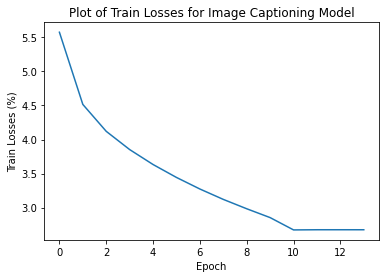

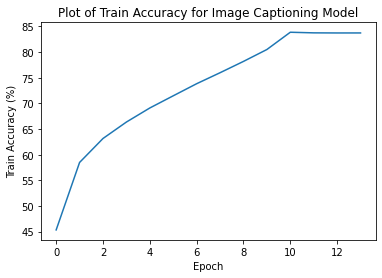

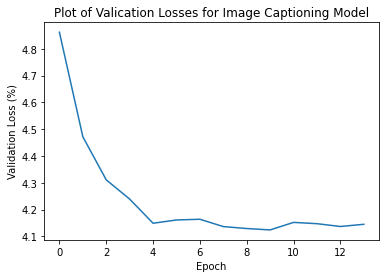

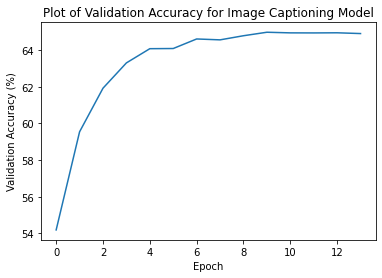

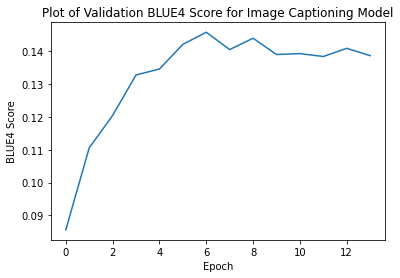

In [148]:

# train_losses = np.array([4.7939, 4.4137, 4.1611, 3.9620, 3.7911, 3.6475, 3.5094, 3.3904, 3.2692, 3.1602, 3.0531, 2.9624, 2.8698, 2.7896, 2.7074, 2.6272, 2.5486, 2.4806, 2.4125, 2.3540, 
#               2.2921, 2.2331, 2.1819, 2.0948, 2.0431, 2.0021, 1.9682, 1.9277, 1.8928, 1.8552, 1.8344, 1.7940, 1.7651, 1.7412, 1.7146, 1.6925, 1.6713, 1.6177, 1.5928, 1.5757,
#               1.5616, 1.5422, 1.5332, 1.5169, 1.5055, 1.4908, 1.4627, 1.4429, 1.4334, 1.4260])
# train_accuracies = np.array([55.22, 60.09, 63.00, 65.37, 67.50, 69.24, 70.99, 72.56, 74.04, 75.66, 77.21, 78.70, 80.17, 81.44, 82.90, 84.15, 85.34, 86.45, 87.50, 88.32,
#                        89.32, 90.09, 90.79, 91.75, 92.49, 93.03, 93.50, 93.93, 94.36, 94.77, 94.96, 95.44, 95.75, 96.05, 96.17, 96.44, 96.57, 96.97, 97.26, 97.40,
#                        97.48, 97.63, 97.69, 97.75, 97.93, 98.03, 98.17, 98.35, 98.42, 98.37])
# validation_losses = np.array([4.6183, 4.4131, 4.2935, 4.2068, 4.1776, 4.1572, 4.1250, 4.1074, 4.1049, 4.1070, 4.1212, 4.1290, 4.1289, 4.1417, 4.1613, 4.1748, 4.2077, 4.2722, 4.2574, 4.2881,
#                    4.3155, 4.3648, 4.3329, 4.3857, 4.4357, 4.4361, 4.4366, 4.5144, 4.5140, 4.5643, 4.5701, 4.5668, 4.6615, 4.6880, 4.6948, 4.7081, 4.7459, 4.7409, 4.8012, 4.8402,
#                    4.8770, 4.8667, 4.9178, 4.9292, 4.9408, 4.9192, 4.9774, 4.9760, 5.0041, 5.0085])
# validation_accuracies = np.array([58.43, 60.78, 62.59, 63.72, 64.01, 64.95, 64.86, 65.28, 65.47, 65.27, 65.29, 65.55, 65.81, 65.95, 65.65, 65.65, 65.11, 64.86, 65.36, 65.41,
#                        64.98, 65.18, 64.98, 65.06, 64.18, 64.79, 64.69, 64.10, 64.01, 64.32, 64.13, 64.01, 63.87, 63.48, 63.53, 63.53, 63.67, 63.95, 63.04, 63.63,
#                        63.54, 63.72, 63.08, 62.99, 62.97, 63.25, 62.79, 62.92, 62.77, 63.21])
# bleu4_scores = np.array([0.1000, 0.1129, 0.1280, 0.1369, 0.1369, 0.1421, 0.1458, 0.1461, 0.1496, 0.1536, 0.1536, 0.1536, 0.1553, 0.1558, 0.1558, 0.1558, 0.1558, 0.1558, 0.1558, 0.1558,
#                 0.1558, 0.1558, 0.1558, 0.1558, 0.1558, 0.1558, 0.1558, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559,
#                 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559, 0.1559])
epochs = [int(x) for x in np.arange(len(train_losses))]
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# !ls /gdrive
# from google.colab import files

# Train loss plot
plt.plot(epochs, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Losses (%)')
plt.title('Plot of Train Losses for Image Captioning Model')
plt.savefig('train_loss.png',bbox_inches='tight')
# files.download("train_loss.png")
plt.show()

# Train accuracy plot
plt.plot(epochs, train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.title('Plot of Train Accuracy for Image Captioning Model')
plt.savefig('train_accuracy.png',bbox_inches='tight')
# files.download("train_accuracy.png")
plt.show()

# Val loss plot
plt.plot(epochs, validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (%)')
plt.title('Plot of Valication Losses for Image Captioning Model')
plt.savefig('val_loss.png',bbox_inches='tight')
# files.download("val_loss.png")
plt.show()

# Val accuracy plot
plt.plot(epochs, validation_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Plot of Validation Accuracy for Image Captioning Model')
plt.savefig('val_accuracy.png',bbox_inches='tight')
# files.download("val_accuracy.png")
plt.show()

# BLEU4 scores plot
# Val accuracy plot
plt.plot(epochs, bleu4_scores)
plt.xlabel('Epoch')
plt.ylabel('BLUE4 Score')
plt.title('Plot of Validation BLUE4 Score for Image Captioning Model')
plt.savefig('bleu4_score.png',bbox_inches='tight')
# files.download("bleu4_score.png")
plt.show()

## **d. Eval**

### **d.1 Define eval function**

In [133]:
def generate_image_caption(encoder, decoder, image_path, word_map, beam_size=5):
    """
    Reads an image and captions it with beam search as well as plot attention maps.
    """
    k = beam_size
    
    # id to word mapping
    rev_word_map = {id: word for word, id in word_map.items()}

    # read and pre-process image
    img = np.array(Image.open(image_path).convert('RGB'))
    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (256, 256))

    # sanity check
    assert img.shape == (256, 256, 3)
    assert np.max(img) <= 255

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = transform(img)    # (3, 256, 256)

    # encode the image
    encoder_out = encoder(img.unsqueeze(0).to(device))     # (1, enc_image_size, enc_image_size, ENCODER_DIM)
    enc_image_size = encoder_out.size(1)
    ENCODER_DIM = encoder_out.size(3)

    # flatten encoded image representation
    encoder_out = encoder_out.view(1, -1, ENCODER_DIM)  # (1, num_pixels, ENCODER_DIM)
    num_pixels = encoder_out.size(1)

    # we'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, ENCODER_DIM)    # (k, num_pixels, ENCODER_DIM)

    # tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words   # (k, 1)

    # tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # lists to store completed sequences along with their alphas and scores
    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, EMBED_DIM)

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, ENCODER_DIM), (s, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (s, enc_image_size, enc_image_size)

        gate = F.sigmoid(decoder.f_beta(h))      # gating scalar, (s, ENCODER_DIM)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
        )   # (s, DECODER_DIM)

        scores = decoder.fc(h)      # (s, VOCAB_SIZE)
        scores = F.log_softmax(scores, dim=1)

        # add the scores to prev scores
        scores = top_k_scores.expand_as(scores) + scores    # (s, VOCAB_SIZE)

        # all the k points will have the same score for the first step (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
        else:
            # unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
        
        # convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // VOCAB_SIZE  # (s)
        next_word_inds = top_k_words % VOCAB_SIZE  # (s)

        # add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)    # (s, step + 1)
        top_k_seqs_alpha = torch.cat(
            [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        )   # (s, step + 1, enc_image_size, enc_image_size)
        
        # which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                            if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # proceed with incomplete sequences
        if k == 0:
            break
        
        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # break if things have been going on too long
        if step > 50:
            break
        step += 1
    
    # select sequence with max score
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    caption = [rev_word_map[ind] for ind in seq]

    img = Image.open(image_path).convert('RGB')
    img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    # plot the image and attention map
    fig = plt.figure(figsize=(20, 8))
    for t in range(len(caption)):
        
        plt.subplot(int(np.ceil(len(caption) / 5.)), 5, t + 1)
        plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(img)

        current_alpha = alphas[t]
        alpha = skimage.transform.pyramid_expand(np.array(current_alpha), upscale=24, sigma=8)
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        
        plt.set_cmap('gray')
        plt.axis('off')

    plt.show()


### **d.2 Eval**

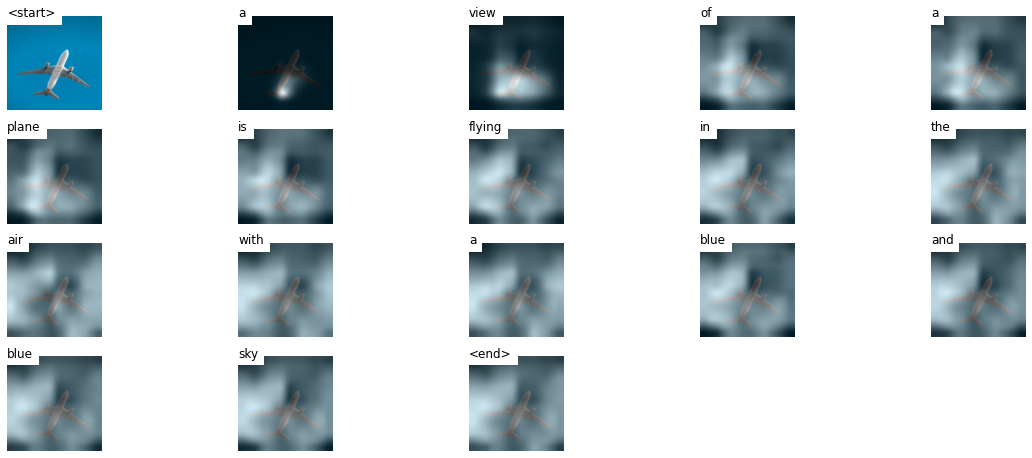

In [136]:
#@title Generate Caption for an Image

image_url = 'https://images.unsplash.com/photo-1531642765602-5cae8bbbf285?ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8YWVyb3BsYW5lfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80' #@param {type:"string"}
beam_size =  10 #@param {type: "number"}

# decoder = torch.load(TORCH_SAVE_PATH + 'best_decoder.pt')
decoder = decoder.to(device)
decoder.eval()
# encoder = torch.load(TORCH_SAVE_PATH + 'best_encoder.pt')
encoder = encoder.to(device)
encoder.eval()

VOCAB_SIZE = len(word2id)
image_path = 'picture.png'

urlretrieve(image_url, image_path)

generate_image_caption(encoder, decoder, image_path, word2id, beam_size)


# FINAL TEST

In [146]:
loss_train, acc_train, bleu4_train = val_epoch(val_loader, encoder, decoder, criterion)

  0%|          | 0/32 [00:00<?, ?it/s]

In [147]:
print("Loss val is", loss_train)
print("Accuracy val is", acc_train)
print("BLEU4 val is", bleu4_train)

Loss val is 4.150078251957893
Accuracy val is 64.80001613120564
BLEU4 val is 0.13866886870127842


In [141]:
loss_test, acc_test, bleu4_test = val_epoch(test_loader, encoder, decoder, criterion)

  0%|          | 0/282 [00:00<?, ?it/s]

In [142]:
print("Loss test is", loss_test)
print("Accuracy test is", acc_test)
print("BLEU4 test is", bleu4_test)

Loss test is 4.222264546874567
Accuracy test is 64.14324753414758
BLEU4 test is 0.1342995684853958


In [ ]:
print(encoder)

In [144]:
print(decoder)

DecoderWithAttention(
  (attention): Attention(
    (encoder_attn): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_attn): Linear(in_features=512, out_features=512, bias=True)
    (full_attn): Linear(in_features=512, out_features=1, bias=True)
  )
  (embedding): Embedding(9490, 512)
  (dropout): Dropout(p=0.2, inplace=False)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (fc): Linear(in_features=512, out_features=9490, bias=True)
)
